In [1]:
import pytensor
import pytensor.tensor as pt

In [2]:
import numpy as np
import jax.numpy as jnp
from jax import lax

In [3]:
import requests
from PIL import Image, ImageSequence
from io import BytesIO
import matplotlib.pyplot as plt
import jax

def load_frames(image: Image, mode='RGBA'):
    return np.array([
        np.array(frame.convert(mode))
        for frame in ImageSequence.Iterator(image)
    ])

In [4]:
url = 'https://media.tenor.com/EGKJGPGeUMAAAAAC/pusheen-cat.gif'
img_raw = requests.get(url).content
gif = Image.open(BytesIO(img_raw))
imgs = load_frames(gif)
img = np.pad(imgs[0], [[10, 10], [10, 10], [0, 0]], 'constant', constant_values=0)


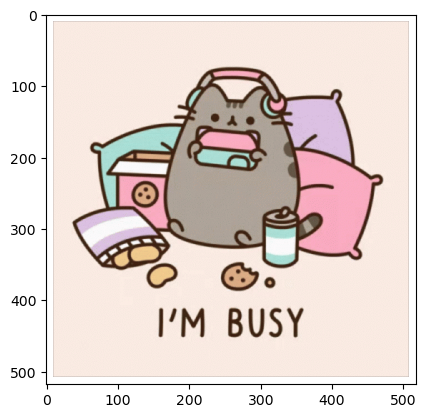

In [5]:
plt.imshow((img / 255))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


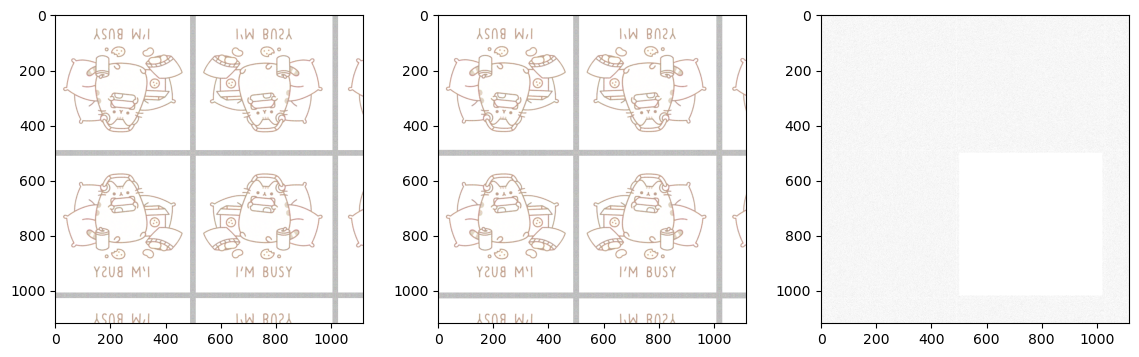

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))
float_img = img / 255 + np.random.beta(a=30, b=30, size=img.shape)
ax[0].imshow(jax.jit(lambda img: jnp.pad(img, [[500, 100], [500, 100], [0, 0]], mode='reflect'))(float_img))
ax[1].imshow(jax.jit(lambda img: jnp.pad(img, [[500, 100], [500, 100], [0, 0]], mode='symmetric'))(float_img))
ax[2].imshow(jax.jit(lambda img: jnp.pad(img, [[500, 100], [500, 100], [0, 0]], mode='symmetric') - jnp.pad(img, [[500, 100], [500, 100], [0, 0]], mode='reflect'))(float_img))

In [7]:
from functools import partial

def symmetric_or_reflect_pad_step(array, curr_pad, edge, edge_slice, before, axis, n, offset, mode, reflect_type):
    if before:
        start = offset
        stop = offset + curr_pad
    else:
        start = -(curr_pad + offset)
        stop = None if (mode == "symmetric" or n == 1) else -1

    x_slice = _slice_at_axis(slice(start, stop), axis=axis)
    x = np.flip(array[x_slice], axis=axis)

    if reflect_type == 'odd':
        x = 2 * edge - x
        if n > 1:
            edge = x[edge_slice]
    if before:
        array = np.concatenate([x, array], axis=axis)
    else:
        array = np.concatenate([array, x], axis=axis)
    return array, edge


def _pad_symmetric_or_reflect(array, pad_width, mode: str, reflect_type: str):
    for i in range(array.ndim):
        n = array.shape[i]
        offset = 1 if (mode == "reflect" and n > 1) else 0
        
        def build_padding(array, padding, before):
            if before:
                edge_slice = _slice_at_axis(slice(0, 1), axis=i)
            else:
                edge_slice = _slice_at_axis(slice(-1, None), axis=i)
            edge = array[edge_slice]
            num_full_reps, remainder = divmod(padding, n - offset)
            curr_pad_values = np.full(num_full_reps, n - offset)
            if remainder > 0:
                curr_pad_values = np.concatenate([curr_pad_values, [remainder]], axis=0)
            
            step = partial(symmetric_or_reflect_pad_step, edge_slice=edge_slice, before=before, axis=i, n=n, offset=offset, mode=mode, reflect_type=reflect_type)
            for curr_pad in curr_pad_values:
                array, edge = step(array, curr_pad, edge)
            
            return array
            
        array = build_padding(array, pad_width[i][0], before=True)
        array = build_padding(array, pad_width[i][1], before=False)
    return array

In [8]:
from functools import partial

def pt_symmetric_or_reflect_pad_step(curr_pad, array, edge, edge_slice, before, axis, n, offset, mode, reflect_type):
    if before:
        start = offset
        stop = offset + curr_pad
    else:
        start = -(curr_pad + offset)
        stop = None if (mode == "symmetric" or n == 1) else -1

    x_slice = _slice_at_axis(slice(start, stop), axis=axis)
    x = flip(array[x_slice], axis=axis)

    if reflect_type == 'odd':
        x = 2 * edge - x
        edge = pytensor.ifelse(pt.gt(n, 1), x[edge_slice], edge)
    if before:
        array = pt.concatenate([x, array], axis=axis)
    else:
        array = pt.concatenate([array, x], axis=axis)
    return array, edge


def _pt_pad_symmetric_or_reflect(array, pad_width, mode: str, reflect_type: str):
    padded, area_slice, pad_width = _symbolic_pad(array, pad_width)
    
    for i in range(array.ndim):
        n = array.shape[i]
        offset = 1 if (mode == "reflect" and n > 1) else 0
        
        def build_padding(array, padding, before):
            if before:
                edge_slice = _slice_at_axis(slice(0, 1), axis=i)
            else:
                edge_slice = _slice_at_axis(slice(-1, None), axis=i)
            edge = array[edge_slice]
            num_full_reps, remainder = pt.divmod(padding, n - offset)
            curr_pad_values = pt.concatenate([pt.full(num_full_reps, n - offset), [remainder] ])
#             pt.full(num_full_reps, n - offset, dtype='int64'))
            
            step = partial(symmetric_or_reflect_pad_step, edge_slice=edge_slice, before=before, axis=i, n=n, offset=offset, mode=mode, reflect_type=reflect_type)
            outputs = pytensor.scan(step,
                                    outputs_info=[edge.astype(float)],
                                    sequences=[curr_pad_values])
            return outputs[0][-1]

        array = build_padding(array, pad_width[i][0], before=True)
        array = build_padding(array, pad_width[i][1], before=False)
    return array

In [13]:
from pytensor.tensor.pad import flip as pt_flip
from pytensor.tensor.pad import _slice_at_axis

def new_symmetric_pad(x, pad_width):
    pad_width = pt.broadcast_to(pad_width, pt.as_tensor((img.ndim, 2)))
    x = pt.as_tensor(x)
    
    for axis in range(x.ndim):
        x_joined = pt.concatenate([x, pt_flip(x, axis=axis)], axis=0)
        shape = x_joined.shape[axis]
        # Compute how many complete copies of the input will be padded on this dimension, along with the amount of
        # overflow on the final copy
        repeats, (left_remainder, right_remainder) = pt.divmod(pad_width[axis], shape)
        
        print('divmod result: ', pt.concatenate([repeats, [left_remainder], [right_remainder]], axis=0).eval())
        # In the next step we will generate extra copies of the input, and then trim them down to the correct size.
    #     # The total number of copies needed is always the sum of the number of complete copies to add, plus the original
    #     # input itself, plus the two edge copies that will be trimmed down.
        total_repeats = pt.maximum(1, (repeats.sum() + (left_remainder > 0) + (right_remainder > 0)))
#         print(repeats.eval(), left_remainder.eval(), right_remainder.eval(), total_repeats.eval())
        print(f'Total repeats: ', total_repeats.eval())
    #     # Create a batch dimension and clone the input the required number of times

        parts = pt.expand_dims(x_joined, (0,)).repeat(total_repeats, axis=0)
        parts = pt.moveaxis(parts, 0, axis)
        
        new_shape = [-1 if i == axis else x.shape[i] for i in range(x.ndim)]
#         print('New Shape:', pt.as_tensor(new_shape).eval())
        x = parts.reshape(new_shape)
        left_trim = 0
        right_trim = x.shape[axis] - (right_remainder)
        print('X before slice:', x.shape.eval())

        print('X before slice:', x.shape.eval())
        trim_slice = _slice_at_axis(slice(left_trim, right_trim), axis)
        print('Trims: ',  pt.as_tensor([left_trim, right_trim]).eval())
        x = x[trim_slice]
        print('X after slice:', x.shape.eval())
        if axis == 0:
            break
    return x

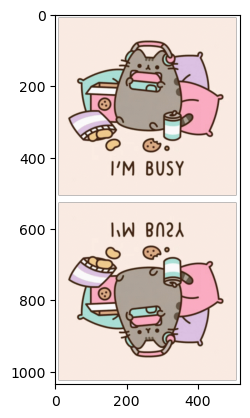

In [14]:
plt.imshow(np.pad(img, [[0, 518], [0, 0], [0, 0]], 'symmetric'));

In [15]:
new_img = new_symmetric_pad(img, [[0, int(0.75 * 518)], [0, 0], [0, 0]])
# plt.imshow(new_img.eval())
# ax[1].imshow(new_img[trim_slice].eval())

divmod result:  [  0   0   0 388]
Total repeats:  1
X before slice: [1036  518    4]
X before slice: [1036  518    4]
Trims:  [  0 648]
X after slice: [648 518   4]


In [ ]:
plt.imshow(new_img.eval())

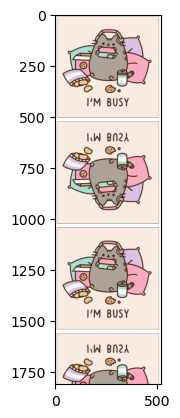

In [681]:
plt.imshow(np.pad(img2, [[0, int(518 * 2.5)], [0,0], [0, 0]], mode='symmetric'));

In [513]:
new_img.shape.eval()

array([1178,   40,    0])

In [333]:
random_img = np.random.beta(1, 1, size=(200, 200, 3))
pad_width3 = [[1000, 10], [10, 12345], [0, 0]]

np.allclose(_pad_symmetric_or_reflect(random_img, pad_width2, 'symmetric', reflect_type='even'),
            jnp.pad(random_img, pad_width2, 'symmetric', reflect_type='even'))

True

In [335]:
np.allclose(_pad_symmetric_or_reflect(random_img, pad_width, 'symmetric', reflect_type='even'), 
            np.pad(random_img, pad_width, 'symmetric', reflect_type='even'))

True

In [86]:
from jax import lax

In [107]:
np.allclose(lax.slice_in_dim(random_img, -1, None, axis=0), _get_edges(random_img, 0, [-2, -1])[1])

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


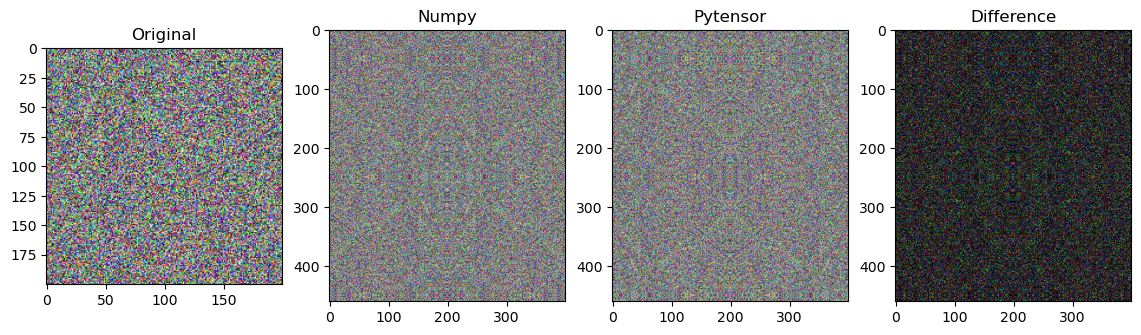

In [84]:
def compare_pad(img, method, **kwargs):
    fig, ax = plt.subplots(1, 4, figsize=(14, 4))
    pt_img = pt.pad(img, mode=method, **kwargs).eval()
    np_img = np.pad(img, mode=method, **kwargs)
    ax[0].imshow(img)
    ax[1].imshow(np_img)
    ax[2].imshow(pt_img)
    ax[3].imshow((np_img - pt_img))
    for axis, title in zip(fig.axes, ['Original', 'Numpy', 'Pytensor', 'Difference']):
        axis.set_title(title)
    plt.show()
        
compare_pad(random_img, 'symmetric', pad_width=[[250, 10], [200, 0], [0, 0]])

1.4545638692884871e-05